# Research on Titanic
2018-1-1


## Data Notes
### Data Dictionary

|Variable|Definition|Key|
|:-|:-|:-|
|survival|Survival|0 = No, 1 = Yes|
|pclass|Ticket class|1=1st,2=2nd,3=3rd|
|sex	|Sex	||
|Age	|Age in years	||
|sibsp	|# of siblings / spouses aboard the Titanic	||
|parch	|# of parents / children aboard the Titanic	||
|ticket	|Ticket number	||
|fare	|Passenger fare	||
|cabin	|Cabin number	||
|embarked	|Port of Embarkation	|C = Cherbourg, Q = Queenstown, S = Southampton|

### Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

## 1.Read the Data

In [15]:
# -*- coding: UTF-8 -*-

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sci
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False
import seaborn as sns
import numpy as np
import re

file_name = 'titanic_data.csv'
data_df = pd.read_csv(file_name)

print (data_df.head())
print '\____________________________________________________________________/'
data_df.info()
print '\____________________________________________________________________/'
data_df.describe()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
\_

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


发现，age 和 cabin这两组数据存在不完整的情况。
因此，对数据进行一些处理，以满足后续分析需要。

## 2.Data Clean
分别查看age 和 cabin确实的数据是什么样的：
发现，Age缺失数据较少，考虑将缺失值填补为中位数。而Cabin缺少数据比较多，且Cabin数据为非数值型。选择将缺失的Cabin填补为NULL。清理完成后发现，embarked还有两个数据为空。与Cabin填充数据方法相同对Embarked进行填补。最终获得数据完整的891组数据。

In [16]:
df_clean = pd.DataFrame(data_df.values.copy(), data_df.index.copy(), data_df.columns.copy())
#该版本的pandas使用  clean_df = data_df.copy(deep = True)依然会报错，猜测是数据进行了深拷贝，但是index和column没有完成深拷贝
df_clean['Age'][df_clean.Age.isnull()] = df_clean['Age'].median()
df_clean['Cabin'][df_clean.Cabin.isnull()] = 'NULL'
df_clean['Embarked'][df_clean.Embarked.isnull()] = 'NULL'
df_clean.info()

df_embarked = pd.get_dummies(df_clean['Embarked'], prefix='Embarked')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null object
Survived       891 non-null object
Pclass         891 non-null object
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null object
SibSp          891 non-null object
Parch          891 non-null object
Ticket         891 non-null object
Fare           891 non-null object
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: object(12)
memory usage: 83.6+ KB


对Cabin数据进行观察，发现

In [17]:
def stage_make(cabin_data):
    i_match = re.match(r'[A-Z][0-9]+', cabin_data)
    if i_match != None:
        return i_match.group()[0]

df_clean['Stage'] = df_clean['Cabin'].apply(stage_make)
df_clean.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Stage
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,NULL,S,None
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,NULL,S,None
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,NULL,S,None


## 3.人员情况

女性人数： 314
男性人数： 577


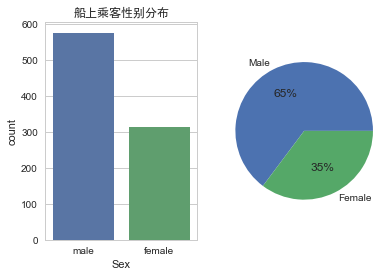

平均年龄：29.3615824916


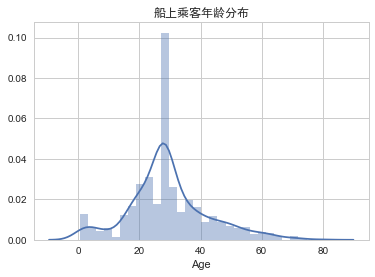

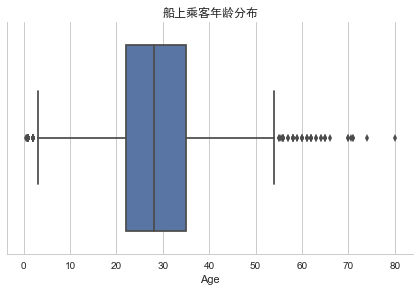

In [39]:
sns.set(style='whitegrid')

plt.subplot(121)
sns.countplot(x='Sex',data=df_clean)
plt.title(u'船上乘客性别分布',fontproperties='SimHei')
plt.subplot(122)
counter = 0
for i in df_clean['Sex']:
    if i=="female":
        counter += 1
female_num = counter
male_num = df_clean['Sex'].count() - counter
print ("女性人数： %s" %female_num)
print ("男性人数： %s" %male_num)
plt.pie([male_num, female_num],labels=['Male', 'Female'], autopct='%1.0f%%' )
plt.axis('equal')
plt.show()

print ("平均年龄：%s" %df_clean['Age'].mean())
sns.distplot(df_clean['Age'],kde=True)
plt.title(u'船上乘客年龄分布',fontproperties='SimHei')
plt.show()
sns.factorplot(x='Age', data=df_clean, kind='box', aspect=1.5)
plt.title(u'船上乘客年龄分布',fontproperties='SimHei')
plt.show()


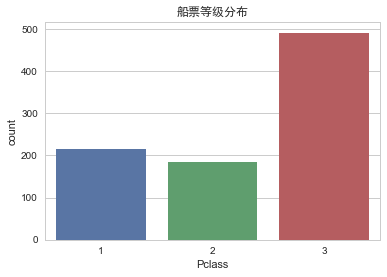

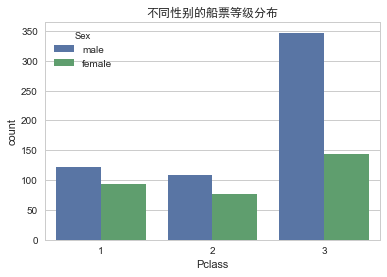

In [36]:
sns.countplot(x='Pclass',data=df_clean)
plt.title(u'船票等级分布',fontproperties='SimHei')
plt.show()
sns.countplot(x='Pclass',data=df_clean, hue='Sex')
plt.title(u'不同性别的船票等级分布',fontproperties='SimHei')
plt.show()

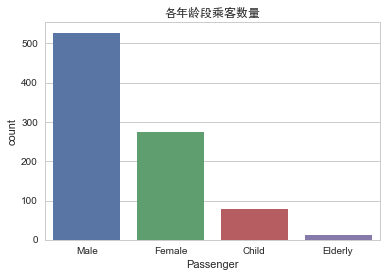

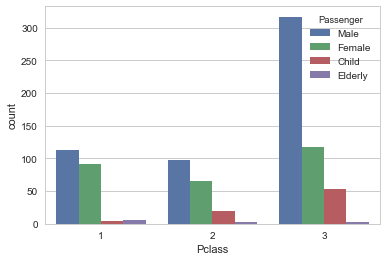

In [30]:
def passenger_spliter(age_sex):
    age,sex = age_sex
    if age < 15:
        return 'Child'
    if age > 64:
        return 'Elderly'
    if age < 65 and age > 14:
        if sex == 'male':
            return 'Male'
        else:
            return 'Female'
        
df_clean['Passenger'] = df_clean[['Age','Sex']].apply(passenger_spliter,axis=1)
sns.countplot(df_clean['Passenger'])
plt.title(u'各年龄段乘客数量',fontproperties='SimHei')
plt.show()

sns.countplot(x='Pclass',data=df_clean, hue='Passenger')
plt.show()


可见，船上乘员平均年龄为29岁，且以青年和中年人居多。其中，男士多于女士近一倍数量。三等票价中男士人数远多于女性。

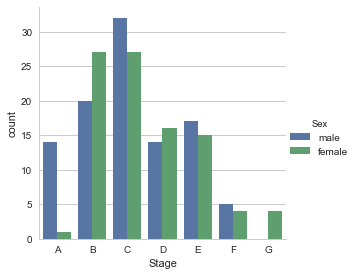

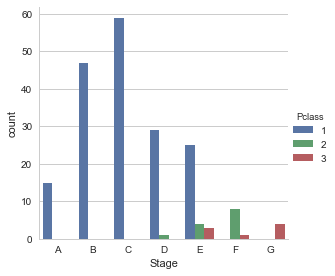

In [86]:
sns.factorplot(x='Stage',data=df_clean, kind='count', order=['A','B','C','D','E','F','G'],hue='Sex')
plt.show()

sns.factorplot(x='Stage',data=df_clean, kind='count', order=['A','B','C','D','E','F','G'],hue='Pclass')
plt.show()

由上图发现，一等票基本上占据了A到E的船票等级，说明船舱位置与船票等级存在一定关系。结合电影剧情，猜测A级船舱应该为最顶层的船舱，而G级船舱应该在轮船底部。
查找资料( http://www.titanic-whitestarships.com/MGY_Tech_Facts.htm ) 发现,该猜想应该是正确的。

## 4. 提出假设
* 生存率与乘客年龄和性别是否有一顶关系？
* 生存率与票价是否有相关性？是否有钱就能活下来？
* 船上有亲属的乘客是否更容易生存？

## 4.生存率分析

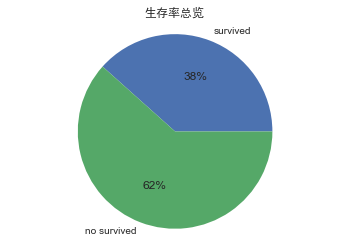

In [21]:

plt.pie([df_clean['Survived'].sum(), df_clean['Survived'].count()-df_clean['Survived'].sum()],
        labels=[ 'survived','no survived'],autopct='%1.0f%%')
plt.axis('equal')
plt.title(u'生存率总览',fontproperties='SimHei')
plt.show()

# print (df_clean.groupby('Survived')['Age'].sum()/df_clean.groupby('Survived')['Age'].count())
# print (df_clean.groupby('Sex')['Survived'].sum()/df_clean.groupby('Sex')['Survived'].count())


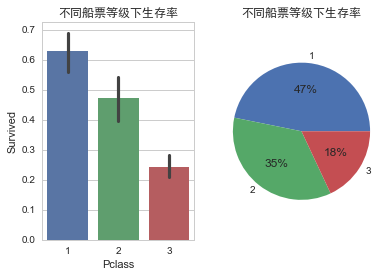

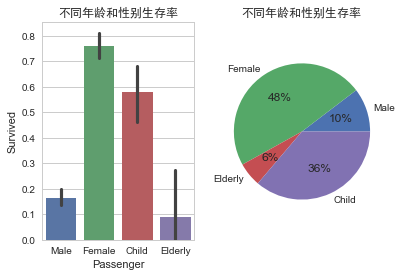

In [79]:
def describe_rate(group_by,target):
    output_rate = dict(df_clean.groupby(group_by)[target].sum()/df_clean.groupby(group_by)[target].count())
    key = output_rate.keys()
    value = []
    for i in output_rate:
        value.append(output_rate[i])
    plt.pie(value, labels=key, autopct='%1.0f%%')
    plt.axis('equal')

plt.subplot(121)
sns.barplot(df_clean['Pclass'], df_clean['Survived'])
plt.title(u'不同船票等级下生存率',fontproperties='SimHei')
plt.subplot(122)
describe_rate('Pclass','Survived')
plt.title(u'不同船票等级下生存率',fontproperties='SimHei')
plt.show()
    
plt.subplot(121)    
sns.barplot(df_clean['Passenger'], df_clean['Survived'])
plt.title(u'不同年龄和性别生存率',fontproperties='SimHei')
plt.subplot(122)
describe_rate('Passenger','Survived')
plt.title(u'不同年龄和性别生存率',fontproperties='SimHei')
plt.show()

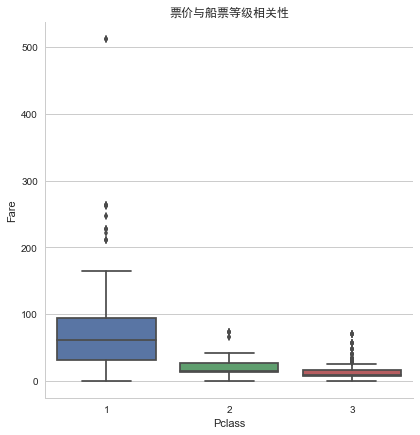

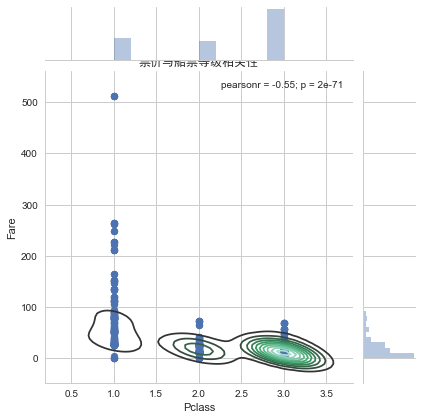

In [85]:
# def correlation(x, y):

#     std_x = (x - x.mean()) / x.std(ddof = 0)
#     std_y = (y - y.mean()) / y.std(ddof = 0)

#     return (std_x * std_y).mean()
sns.factorplot(x='Pclass', y='Fare', data=df_clean, kind='box',size=6, aspect=1)
plt.title(u'票价与船票等级相关性',fontproperties='SimHei')
plt.show()
sns.jointplot(x='Pclass', y='Fare', data=df_clean, kind='scatter' ,stat_func=sci.pearsonr).plot_joint( sns.kdeplot)
plt.title(u'票价与船票等级相关性',fontproperties='SimHei')
plt.show()


由上图可见，事故发生后女士和儿童的生存率较高。相比之下，老年人的生存率最低。体现了事故发生后妇女儿童优先的原则。由此也可以确定乘客年龄和性别对生存率有较大影响。同时，票价等级的高低能够对生存率产生一定影响。船票等级越高，生存的可能性越大。但是通过分析船票等级和票价可以看出，船票价格和乘客的等级不具有太大相关性。因此，比起船票价格，船票等级更适合作为事故发生后生存率判断的依据。

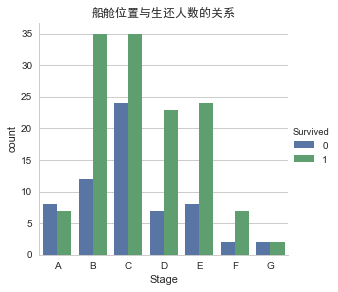

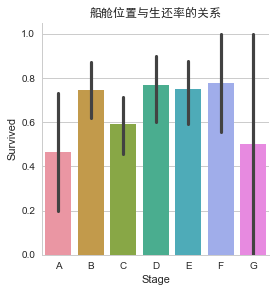

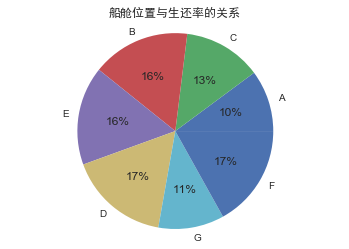

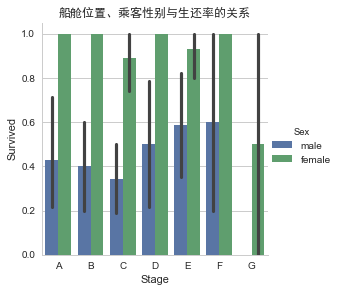

In [129]:
sns.factorplot(x='Stage',data=df_clean, kind='count', order=['A','B','C','D','E','F','G'],hue='Survived')
plt.title(u'船舱位置与生还人数的关系',fontproperties='SimHei') 
plt.show()


sns.factorplot(x='Stage', y='Survived', data=df_clean, kind='bar', order=['A','B','C','D','E','F','G'])
plt.title(u'船舱位置与生还率的关系',fontproperties='SimHei') 
plt.show()
describe_rate('Stage','Survived')
plt.title(u'船舱位置与生还率的关系',fontproperties='SimHei') 
plt.show()

sns.factorplot(x='Stage',y='Survived',data=df_clean,hue='Sex',kind='bar',order=['A','B','C','D','E','F','G'],size=4,aspect=1)
plt.title(u'船舱位置、乘客性别与生还率的关系',fontproperties='SimHei') 
plt.show()

由上图可见，A层和G层的乘客生还率最低，并且G层男性乘客全员牺牲。结合上面关于船舱位置的猜测，G层乘客生还率低的原因可能是由于这两层的乘客距离救生艇较远，从而无法及时获得救助。而A层乘客生还率较低的原因可能是因为A层甲板上，男士的人数远多于女士，绝大多数的生存机会都留给了女性。说明，在事故发生后泰坦尼克号上的男士们很好地践行了骑士精神。

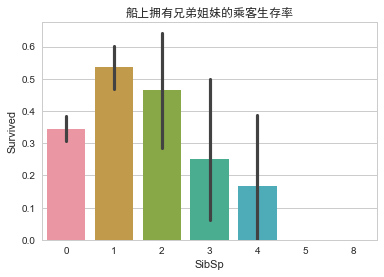

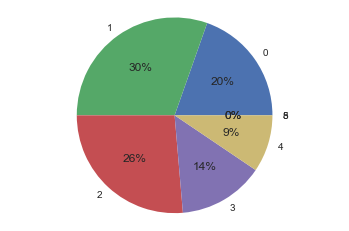

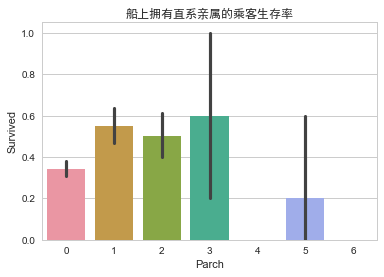

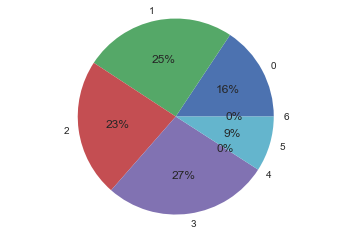

In [132]:
sns.barplot(df_clean['SibSp'], df_clean['Survived'])
plt.title(u'船上拥有兄弟姐妹的乘客生存率',fontproperties='SimHei')
plt.show()

describe_rate('SibSp','Survived')
plt.show()

sns.barplot(df_clean['Parch'], df_clean['Survived'])
plt.title(u'船上拥有直系亲属的乘客生存率',fontproperties='SimHei')
plt.show()
describe_rate('Parch','Survived')
plt.show()

如上图所示，没有兄弟姐妹的乘客生还率为20%。没有父母或孩子的乘客生还率更低，仅为16%

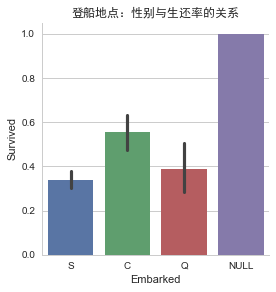

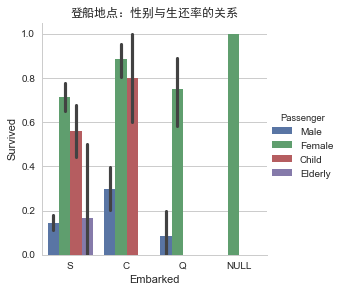

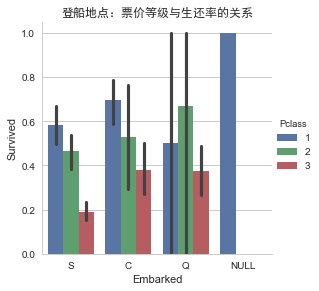

In [142]:
sns.factorplot(x='Embarked',y='Survived',data=df_clean,kind='bar',size=4,aspect=1)
plt.title(u'登船地点：性别与生还率的关系',fontproperties='SimHei') 
plt.show()
sns.factorplot(x='Embarked',y='Survived',hue='Passenger',data=df_clean,kind='bar',size=4,aspect=1)
plt.title(u'登船地点：性别与生还率的关系',fontproperties='SimHei') 
plt.show()
sns.factorplot(x='Embarked',y='Survived',hue='Pclass',data=df_clean,kind='bar',size=4,aspect=1)
plt.title(u'登船地点：票价等级与生还率的关系',fontproperties='SimHei') 
plt.show()

由上图发现C地上船的乘客生还率要高于其他地方登船的乘客。详细分析后发现，导致该现象的原因主要是因为C地登录的乘客中妇女儿童占比明显要比其他两地更多。因此，性别和年龄仍然是主导生还率的重要因素之一。

## 5.总结

经过分析后发现，妇女儿童在此次灾难中得到了很好的保护，男士和老年人在事故中丧生比率较高，且一等舱男士更倾向牺牲自我。统计发现，在船上还有其他亲属的乘客更容易存活。乘客在船舱住址虽然样本数据量较小，但是可以发现位于船体中上位置的乘客更容易存活，相比之下，位于船舱底部的男性来说本次事故则显得相当惨烈。